### Imports

In [26]:
import os
import sys
import glob
import csv
import time
import platform
import socket
import random
import cv2
import re
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, List, Callable

In [27]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image, ImageFilter
from dataclasses import dataclass

In [28]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

# Model

In [29]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [30]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # i learned about this in class today! the timing in on point!
        return self.conv(x) + self.residual(x)

class MotionVectorRegressionNetwork(nn.Module):
    def __init__(self, input_images = 2):
        super().__init__()
        # Outputs an xy motion vector per pixel
        self.input_images = input_images
        self.vector_channels = 2

        self.convolution = nn.Sequential(
            ConvolutionBlock(input_images, 32, kernel_size=3), # input_images (2) -> 32 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(32, 64, kernel_size=3), # 32 -> 64 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(64, 128, kernel_size=3), # 64 -> 128 channels 
            ConvolutionBlock(128, 128, kernel_size=3), # 128 -> 128 channels
        ) 

        self.output = nn.Sequential(
            # scale back up
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 128 -> 64 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 64 -> 32 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.vector_channels, kernel_size=3, stride=1, padding=1), # 32 -> 2 channels
        )

    def forward(self, x):
        # print(x.shape)
        x = self.convolution(x)
        # print(x.shape)
        x = self.output(x)
        # print(x.shape)
        return x

model = MotionVectorRegressionNetwork(input_images=2).to(device)
print(model)

MotionVectorRegressionNetwork(
  (convolution): Sequential(
    (0): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0):

# Testing

In [31]:
# testin gthe model

MODEL_FILE = "model2/tx7.pth"

model = MotionVectorRegressionNetwork().to(device)
model.load_state_dict(torch.load(MODEL_FILE, weights_only=True))

<All keys matched successfully>

In [32]:
@dataclass
class Tile:
    data: np.ndarray
    position: Tuple[int, int]  # (y, x) position in original image
    size: int
    overlap: int

In [33]:
size: int = 256
overlap: int = 32
def create_tiles(image: np.ndarray) -> List[Tile]:
    """Split image into overlapping tiles."""
    height, width = image.shape
    tiles = []

    for y in range(0, height - overlap, size - overlap):
        for x in range(0, width - overlap, size - overlap):
            # Calculate tile boundaries
            y_end = min(y + size, height)
            x_end = min(x + size, width)
            
            # Extract tile data
            tile_data = image[y:y_end, x:x_end]
            
            # Pad if necessary
            if tile_data.shape != (size, size):
                padded_data = np.zeros((size, size), dtype=tile_data.dtype)
                padded_data[:tile_data.shape[0], :tile_data.shape[1]] = tile_data
                tile_data = padded_data
            
            tiles.append(Tile(
                data=tile_data,
                position=(y, x),
                size=size,
                overlap=overlap
            ))
            
    return tiles

In [34]:
def stitch_tiles(tiles: List[Tile], original_shape: tuple) -> np.ndarray:
    """Stitch tiles back together with average blending in overlap regions."""
    height, width = original_shape
    result = np.zeros(original_shape, dtype=np.uint8)
    weights = np.zeros(original_shape, dtype=np.float32)


    for tile in tiles:
        y, x = tile.position
        y_end = min(y + tile.size, height)
        x_end = min(x + tile.size, width)
        
        # Create weight mask for smooth blending
        weight_mask = np.ones((y_end - y, x_end - x), dtype=np.float32)
        
        # Apply feathering at edges
        if tile.overlap > 0:
            # Feather left edge
            if x > 0:
                weight_mask[:, :tile.overlap] = np.linspace(0, 1, tile.overlap)
            # Feather right edge
            if x_end < width:
                weight_mask[:, -tile.overlap:] = np.linspace(1, 0, tile.overlap)
            # Feather top edge
            if y > 0:
                weight_mask[:tile.overlap, :] *= np.linspace(0, 1, tile.overlap)[:, np.newaxis]
            # Feather bottom edge
            if y_end < height:
                weight_mask[-tile.overlap:, :] *= np.linspace(1, 0, tile.overlap)[:, np.newaxis]
        
        # Add weighted tile data
        result[y:y_end, x:x_end] += (tile.data[:y_end-y, :x_end-x] * weight_mask).astype(np.uint8)
        weights[y:y_end, x:x_end] += weight_mask
        
    # Normalize by weights to get final image
    mask = weights > 0
    result[mask] = (result[mask] * weights[mask]).astype(np.uint8)
    
    return result

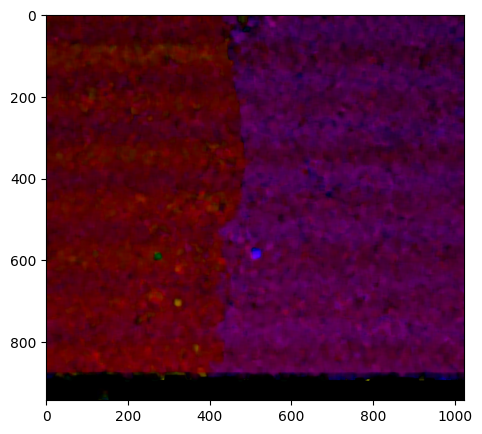

In [ ]:
model.eval()

# print(sequence_arrays)
# sequence_array[sequence_name][tile index][time index]

sequence_name = 'g78'
mum_tiles = 41
# frames = [72, 73]
# num_tiles = len(sequence_arrays[sequence_name].keys())

# base_image_path = sequence_arrays['g78'][11][72]
# next_time_path = sequence_arrays['g78'][11][73]
RAW_DIR = "../raw"

image1_path = os.path.join(RAW_DIR, sequence_name, "00073.tif") # "00035.tif" -> "00076.tif"
image2_path = os.path.join(RAW_DIR, sequence_name, "00074.tif")


img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    print(f"Error: Could not load images. Please check image paths: {image1_path}, {image2_path}")

# 2. Calculate Dense Optical Flow using Farneback algorithm
flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# 3. Visualize Dense Optical Flow using color coding

h, w = img1.shape[:2]
hsv = np.zeros((h, w, 3), dtype=np.uint8)
hsv[..., 1] = 255  # Set saturation to maximum

mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) # Convert flow vectors to magnitude and angle

hsv[..., 0] = ang * 180 / np.pi / 2 # Map angle to hue (0-180 range for OpenCV HSV)
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) # Normalize magnitude to 0-255 and map to value

bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR) # Convert HSV to BGR for display


plt.figure(figsize=(20, 5))
plt.imshow(bgr)
plt.show()

In [ ]:
def load_and_process_frame_pair(frame1_num, frame2_num, sequence_name, raw_dir, blur=True):
    # Load consecutive frames
    image1_path = os.path.join(raw_dir, sequence_name, f"{frame1_num:05d}.tif")
    image2_path = os.path.join(raw_dir, sequence_name, f"{frame2_num:05d}.tif")
    
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # blur the images
    img1 = cv2.GaussianBlur(img1, (5, 5), 0)
    img2 = cv2.GaussianBlur(img2, (5, 5), 0)
    
    if img1 is None or img2 is None:
        raise ValueError(f"Could not load images: {image1_path}, {image2_path}")
    
    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Convert to color visualization
    h, w = img1.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def animate_sequence(sequence_name, start_frame=35, end_frame=76, raw_dir="../raw"):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    def update(frame):
        ax.clear()
        bgr = load_and_process_frame_pair(frame, frame+1, sequence_name, raw_dir)
        ax.imshow(bgr)
        ax.set_title(f'Optical Flow Frame {frame} -> {frame+1}')
        ax.axis('off')
    
    anim = FuncAnimation(fig, update, frames=range(start_frame, end_frame),
                        interval=200, repeat=True)
    
    # Save animation
    anim.save(f'optical_flow_{sequence_name}.gif', writer='pillow')
    plt.close()

# Run the animation
sequence_name = 'g78'
animate_sequence(sequence_name)

In [40]:
def load_and_process_frame_pair(frame1_num, frame2_num, sequence_name, raw_dir):
    # Load consecutive frames
    image1_path = os.path.join(raw_dir, sequence_name, f"{frame1_num:05d}.tif")
    image2_path = os.path.join(raw_dir, sequence_name, f"{frame2_num:05d}.tif")
    
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # blur the images
    img1 = cv2.GaussianBlur(img1, (5, 5), 0)
    img2 = cv2.GaussianBlur(img2, (5, 5), 0)
    
    if img1 is None or img2 is None:
        raise ValueError(f"Could not load images: {image1_path}, {image2_path}")
    
    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Convert to color visualization
    h, w = img1.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def animate_sequence(sequence_name, start_frame=35, end_frame=76, raw_dir="../raw"):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    def update(frame):
        ax.clear()
        bgr = load_and_process_frame_pair(frame, frame+1, sequence_name, raw_dir)
        ax.imshow(bgr)
        ax.set_title(f'Optical Flow Frame {frame} -> {frame+1}')
        ax.axis('off')
    
    anim = FuncAnimation(fig, update, frames=range(start_frame, end_frame),
                        interval=200, repeat=True)
    
    # Save animation
    anim.save(f'optical_flow_blur_{sequence_name}.gif', writer='pillow')
    plt.close()

# Run the animation
sequence_name = 'g78'
animate_sequence(sequence_name)

(943, 1024)
(943, 1024)
(943, 1024, 3)
(943, 1024, 3)
(943, 1024, 3)


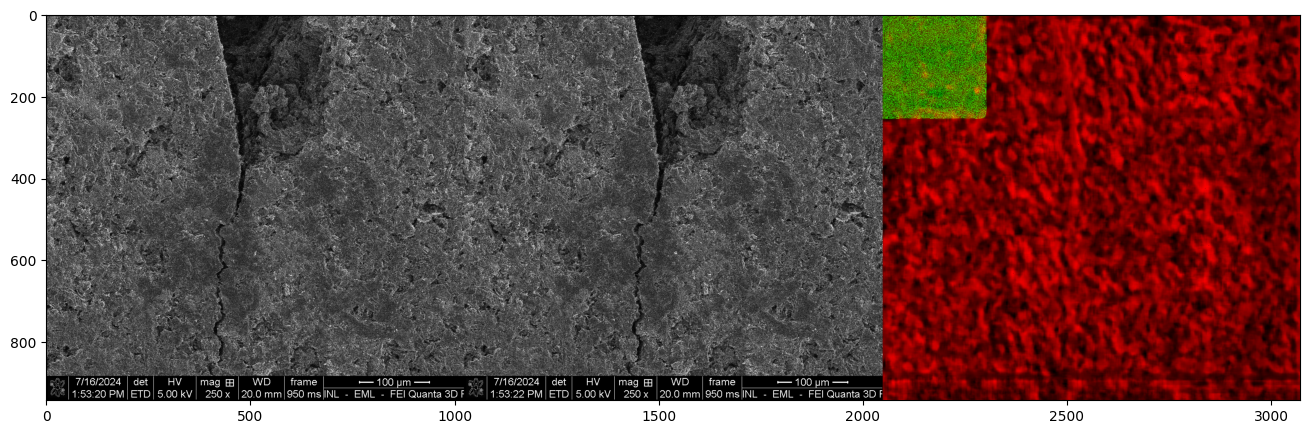

In [38]:
image1 = np.array(Image.open(image1_path), dtype=np.uint8)
image2 = np.array(Image.open(image2_path), dtype=np.uint8)

print(image1.shape)

image1_tiles = create_tiles(image1)
image2_tiles = create_tiles(image2)

out_tilesx = []
out_tilesy = []
with torch.no_grad():
    for i, tile1 in enumerate(image1_tiles):
        tile_position = tile1.position
        
        tile2 = image2_tiles[0]
        for tmptile in image2_tiles:
            if tile_position == tile2.position:
                tile2 = tmptile
                break
        
        stacked = np.stack([tile1.data, tile2.data], axis=0)
        # print(stacked.shape)

        batch = torch.from_numpy(np.array([stacked])).float().to(device)
        pred = model(batch)
        # print(pred.shape)

        converted_pred = pred[0].cpu().numpy()
        # converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
        converted_predx = converted_pred[0]
        converted_predx = (converted_predx - converted_predx.min()) / (converted_predx.max() - converted_predx.min())
        converted_predx = converted_predx * 256

        converted_predy = converted_pred[1]
        converted_predy = (converted_predy - converted_predy.min()) / (converted_predy.max() - converted_predy.min())
        converted_predy = converted_predy * 256

        out_tilesx.append(Tile(data=converted_predx, position=tile1.position, size=tile1.size, overlap=tile1.overlap))
        out_tilesy.append(Tile(data=converted_predy, position=tile2.position, size=tile2.size, overlap=tile2.overlap))

out_stichedx = stitch_tiles(out_tilesx, image1.shape)
out_stichedy = stitch_tiles(out_tilesy, image2.shape)

print(out_stichedx.shape)

out_st = np.stack((out_stichedx, out_stichedy, np.zeros(out_stichedx.shape)))
out_st = np.transpose(out_st, (1, 2, 0))

image1 = np.array((image1,) * 3)
image1 = np.transpose(image1, (1, 2, 0))
image2 = np.array((image2,) * 3)
image2 = np.transpose(image2, (1, 2, 0))

print(out_st.shape)
print(image1.shape)
print(image2.shape)

combined = np.hstack((image1, image2, out_st)).astype(np.uint8)

plt.figure(figsize=(20, 5))
plt.imshow(combined)
plt.show()